In [1]:
import os
import time


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch


from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [2]:
N_THREADS = 12
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 2*3600
TARGET_NAME = 'loss'

In [3]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [4]:
%%time

train_data = pd.read_csv('./data/train.csv',index_col=0)
train_data.head()

Wall time: 1.85 s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
id,,,,,,,,,,,,,,,,,,,,,
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [5]:
%%time

test_data = pd.read_csv('./data/test.csv',index_col=0)
test_data.head()

Wall time: 1.11 s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
id,,,,,,,,,,,,,,,,,,,,,
250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,1.11394,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,1.09695,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,1.15222,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,1.20157,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,1.16807,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660


In [6]:
%%time

tr_data, te_data = train_test_split(train_data, 
                                    test_size=TEST_SIZE, 
                                    stratify=train_data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (200000, 101), te_data = (50000, 101)
Wall time: 266 ms


In [7]:
%%time

def rmse(y_true, y_pred, **kwargs):
    return mean_squared_error(y_true, y_pred, squared = False, **kwargs)

task = Task('reg', )#metric = rmse)

Wall time: 0 ns


In [8]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['id']
         }

Wall time: 0 ns


In [9]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       tuning_params = {'max_tuning_time': 600},
                       general_params = {'use_algos': [['lgb', 'lgb_tuned', 'cb','cb_tuned']]},
                       verbose = 2 # Available values: 0,1,2,3 (from less detailed to more)
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(tr_data, roles = roles)

[log_lvl_2] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 7200.00 seconds
[log_lvl_1] - cpus: 12 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (200000, 101)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 7184.34 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_1] Algo = Lvl_0_

Wall time: 262 ms


<AxesSubplot:xlabel='Feature'>

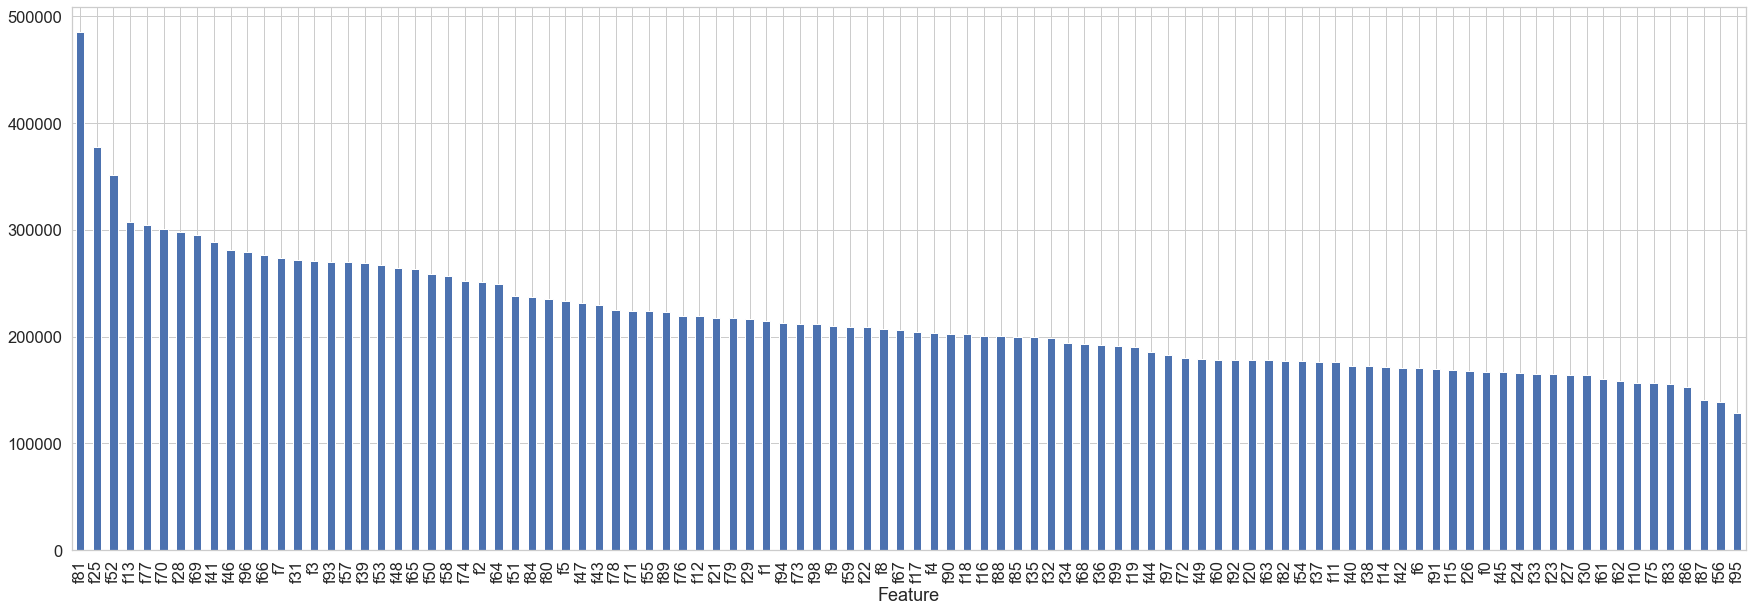

In [10]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [11]:
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[6.1645517],
       [7.4262857],
       [7.325094 ],
       ...,
       [7.309105 ],
       [6.270347 ],
       [6.802094 ]], dtype=float32)
Shape = (50000, 1)
Wall time: 6.51 s


In [12]:
def rmse(y_true, y_pred, **kwargs):
    return mean_squared_error(y_true, y_pred, squared = False, **kwargs)

print('Check scores...')
print('OOF score: {}'.format(rmse(tr_data[TARGET_NAME].values, oof_pred.data[:len(tr_data), 0])))
print('HOLDOUT score: {}'.format(rmse(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 7.852029408169134
HOLDOUT score: 7.844967646943462


In [13]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       tuning_params = {'max_tuning_time': 600},
                       general_params = {'use_algos': [['lgb', 'lgb_tuned', 'cb','cb_tuned']]},
                       verbose = 1
                      )

oof_pred = automl.fit_predict(train_data, roles = roles)

[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 7200.00 seconds
[log_lvl_1] - cpus: 12 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (250000, 101)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 7185.12 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_0_LightGBM, score = -61.699127224606656
[log_lvl_1] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[log_lvl_1] Optuna may run 1614.9634030515497 secs
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM, score = -61.68272891130154
[log_lvl_1] Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_2_CatBoost ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_2_CatBoost, score = -61.6987

In [14]:
print('Check scores...')
print('OOF score: {}'.format(rmse(train_data[TARGET_NAME].values, oof_pred.data[:len(train_data), 0])))

Check scores...
OOF score: 7.846150339046407


In [15]:
test_pred = automl.predict(test_data)
print('Prediction for test_data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))

Prediction for test_data:
array([[8.019851 ],
       [4.885459 ],
       [7.9957223],
       ...,
       [6.2354984],
       [5.789607 ],
       [6.879425 ]], dtype=float32)
Shape = (150000, 1)


In [16]:
samp_sub = pd.DataFrame()

In [17]:
samp_sub['id']  = test_data.index.copy()
samp_sub[TARGET_NAME] = test_pred.data[:, 0]
samp_sub.to_csv('LightAutoML_submission.csv', index = False)

In [18]:
samp_sub

,id,loss
0,250000,8.019851
1,250001,4.885459
2,250002,7.995722
3,250003,7.414481
4,250004,7.713197
...,...,...
149995,399995,7.267390
149996,399996,7.096814
149997,399997,6.235498
149998,399998,5.789607
